# Регрессия - пора творить!

Если вы дошли до этой практики и выполнили все предыдущие - вау! Аплодисменты вам!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/leo.png" width=500/></p>



Тем не менее, не время расслабляться! На этот раз мы не будем рассказывать вам новый материал - лишь дадим пару напутствий и пожелаем успехов и сил!

В этот раз вам предлагается разработать модель предсказания цены домов по набору данных Boston Houses Pricing. Мы его уже немного пощупали в прошлой практике, но в этой вам предстоит сделать всё самостоятельно и на полных данных!

Что надо будет сделать:
- загрузить данные;
- посмотреть и размер, и примеры данных;
- проверить количество пропусков в данных;
    - убедиться, что пропусков в данных нет и можно строить **baseline**;
- разделить данные на train и test;
    - Делаем это один раз! Все дальнейшие модификации и улучшения должны делаться на основе единственного разделения!
    - И не забудьте зафиксировать сид! Переменную `RANDOM_SEED` мы даём ниже;
- создать baseline модель, получить метрики на тестовой выборке;
- проанализировать данные, подготовить план по очистке и предобработке данных;
- создать функцию очистки;
- произвести очистку train и test выборок -> обучаем модель с очищенными данными;
    - Снимаем метрики и так мы оцениваем влияние очистки данных на обучение;
- создать класс предобработки данных;
- сделать предобработку очищенных данных -> обучаем модель;
    - Снимаем метрики и так мы оцениваем влияние предобработки данных на обучение;

А дальше можете пофантазировать, почитать интернет и посмотреть, как улучшить метрики! 

**Ваша цель - достигнуть наилучших показателей!**

Вот вам пара идей по интересной организации предобработке:
- по признаку `CRIM` создать признак `is_CRIM`, который будет равен 1, если `CRIM` не равен 0 и 0, если `CRIM` равен нулю;
- сделать обучение модели [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), посмотреть, какие признаки имеют веса близкие к 0 и убрать их из обучения как незначимые;
- оставить только признаки с высокой корреляцией с целевой переменной;
- посмотреть, какие переменные коррелирцют между собой и оставить только единственные из пар коррелирующих;
- посмотреть, в каких примерах данных модель ошибается сильнее всего (отсортировать записи из теста по величине ошибки) и проанализировать, есть ли какая-то зависимость или шум;
- комбинировать разные подходы в зависимости от того, помогает это предсказаниям или нет.

Ещё большим плюсом будет, если вы покажете, как влияет каждый этап предобработки на результаты обучения!

In [2]:

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
TEXT_COLOR = "black"

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["text.color"] = TEXT_COLOR
plt.rcParams["font.size"] = 14
plt.rcParams["lines.markersize"] = 15
plt.rcParams["axes.labelcolor"] = TEXT_COLOR
plt.rcParams["xtick.color"] = TEXT_COLOR
plt.rcParams["ytick.color"] = TEXT_COLOR

sns.set_style("darkgrid")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
df_src = pd.read_csv("boston.csv")

In [4]:
df_src.shape

(506, 14)

In [5]:
df_src.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [6]:
df_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [7]:
df_src.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [8]:
train_data, test_data = train_test_split(df_src, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

In [9]:
target_column = 'MEDV'

X_train = train_data.drop(columns=[target_column])
y_train = train_data[target_column]
X_test = test_data.drop(columns=[target_column])
y_test = test_data[target_column]

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_test_pred = baseline_model.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(mse)
print(mae)
print(r2)

24.291119474973538
3.1890919658878416
0.6687594935356317


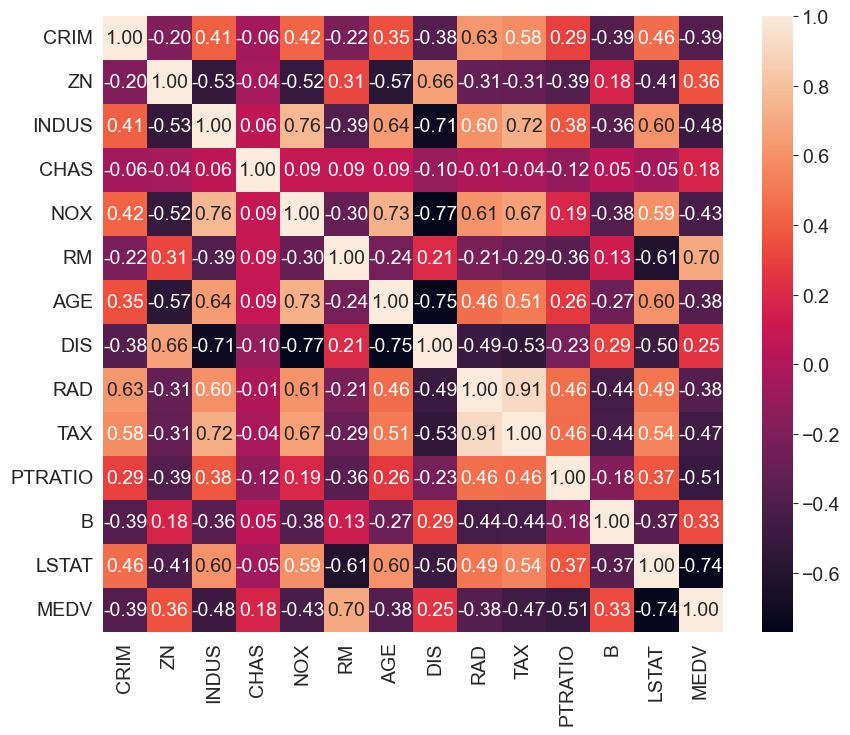

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64


In [10]:
corr_matrix = df_src.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()
correlation_with_target = corr_matrix[target_column].sort_values(ascending=False)
print(correlation_with_target)

In [11]:
def clean_dataset(df):
    df_cleaned = df.copy()
    return df_cleaned

In [ ]:
train_data_cleaned = clean_dataset(train_data)
test_data_cleaned = clean_dataset(test_data)

X_train_cleaned = train_data_cleaned.drop(columns=[target_column])
y_train_cleaned = train_data_cleaned[target_column]
X_test_cleaned = test_data_cleaned.drop(columns=[target_column])
y_test_cleaned = test_data_cleaned[target_column]

cleaned_model = LinearRegression()
cleaned_model.fit(X_train_cleaned, y_train_cleaned)
y_test_pred_cleaned = cleaned_model.predict(X_test_cleaned)

mse_cleaned = mean_squared_error(y_test_cleaned, y_test_pred_cleaned)
mae_cleaned = mean_absolute_error(y_test_cleaned, y_test_pred_cleaned)
r2_cleaned = r2_score(y_test_cleaned, y_test_pred_cleaned)

print(mse_cleaned)
print(mae_cleaned)
print(r2_cleaned)

24.291119474973538
3.1890919658878416
0.6687594935356317


In [16]:
class DataPreprocessing:
    def fit(self, df):
        self.columns = df.columns
        self.means = df.mean()
        self.stds = df.std()

    def transform(self, df):
        df_scaled = (df - self.means) / self.stds
        return df_scaled

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

In [ ]:
preprocessor = DataPreprocessing()
X_train_preprocessed = preprocessor.fit_transform(X_train_cleaned)
X_test_preprocessed = preprocessor.transform(X_test_cleaned)

preprocessed_model = LinearRegression()
preprocessed_model.fit(X_train_preprocessed, y_train_cleaned)
y_test_pred_preprocessed = preprocessed_model.predict(X_test_preprocessed)

mse_preprocessed = mean_squared_error(y_test_cleaned, y_test_pred_preprocessed)
mae_preprocessed = mean_absolute_error(y_test_cleaned, y_test_pred_preprocessed)
r2_preprocessed = r2_score(y_test_cleaned, y_test_pred_preprocessed)

print("Модель после предобработки:")
print(f"MSE: {mse_preprocessed:.2f}")
print(f"MAE: {mae_preprocessed:.2f}")
print(f"R²: {r2_preprocessed:.2f}")

Модель после предобработки:
MSE: 24.29
MAE: 3.19
R²: 0.67


In [19]:

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
def lasso_model(train_data, test_data, alpha=0.01):
    X_train = train_data.drop("MEDV", axis=1)
    y_train = train_data["MEDV"]
    X_test = test_data.drop("MEDV", axis=1)
    y_test = test_data["MEDV"]
    
    assert y_train.isnull().sum() == 0, "есть пропуски в обучающих данных"
    assert y_test.isnull().sum() == 0, "есть пропуски в тестовых данных"
    
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"R2: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}")
    return model, r2, mae, mse

lasso_model(train_data_cleaned, test_data_cleaned, alpha=0.01)

R2: 0.6686, MAE: 3.1605, MSE: 24.3033


(Lasso(alpha=0.01), 0.6685929109949444, 3.160452414869678, 24.30333560289059)

Что мы ждем от вас? 

Готовый ноутбук с таким же названием, в котором будут обязательные пункты с выводами по анализу данных и анализу поведения модели, а также дополнительные пункты с вашими мыслями и результатами улучшения модели.

Успехов вам, мы в вас верим, вы точно справитесь!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/cat-computer-peek-out-36960208.jpg" width=600/></p>